***Female-Male Voice Classifier***

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [12]:
!unzip -qq "/content/drive/MyDrive/raw16k" -d "/content/"

***노이즈 데이터와 가우시안 필터링 적용 데이터 스펙토그램 비교분석***



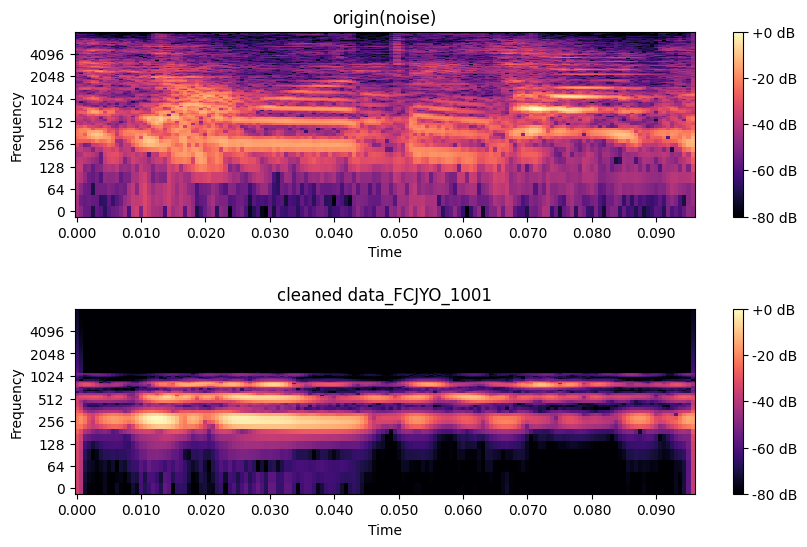

In [ ]:
import numpy as np
import wave
import librosa.display
import matplotlib.pyplot as plt
from scipy.signal import firwin, lfilter, medfilt

from scipy.signal import butter, filtfilt

# PCM 파일을 읽어들일 함수
def read_pcm(file_path, sample_rate=16000, dtype='<i2'):
    with open(file_path, 'rb') as f:
        data = np.frombuffer(f.read(), dtype=dtype)
    return data.astype(np.float32), sample_rate  # 부동 소수점 타입으로 변환

def pcm_to_wav(pcm_data, sample_rate, file_path):
    # PCM 데이터를 16비트로 변환
    pcm_data = np.int16(pcm_data)

    # WAV 파일 열기
    with wave.open(file_path, 'wb') as wav_file:
        # WAV 파일 설정
        wav_file.setnchannels(1)  # 모노 채널
        wav_file.setsampwidth(2)  # 16비트
        wav_file.setframerate(sample_rate)  # 샘플레이트 설정
        # 데이터 쓰기
        wav_file.writeframes(pcm_data.tobytes())


def apply_bandpass_filter(data, fs):
    """
    40~300Hz 주파수 대역의 FIR 필터를 적용하여 데이터를 처리하는 함수

    Parameters:
        - data (array_like): 입력 데이터
        - fs (float): 샘플링 주파수 (Hz)

    Returns:
        - filtered_data (array_like): 필터링된 결과 데이터
    """
    # 주파수 대역 설정
    lowcut = 100  # 최소 주파수 (Hz)
    highcut = 1000  # 최대 주파수 (Hz)
    nyq = 0.5 * fs  # 나이퀴스트 주파수

    # 필터 길이 계산
    numtaps = 321  # 필터 길이 (홀수)

    # FIR 필터 계수 생성
    taps = firwin(numtaps, [lowcut / nyq, highcut / nyq], pass_zero=False)

    # FIR 필터 적용
    filtered_data = lfilter(taps, 1.0, data)

    return filtered_data


def generate_combined_gaussian_weights(mean_freqs, std_dev, freq_range):
    # 가우시안 함수 정의
    def gaussian(x, mean, std_dev):
        return np.exp(-((x - mean) / std_dev) ** 2 / 2) / (std_dev * np.sqrt(2 * np.pi))

    # 가우시안 분포 생성 및 조절
    gaussian_weights = []
    for idx, mean_freq in enumerate(mean_freqs):
        gaussian_weight = gaussian(freq_range, mean_freq, std_dev)
        gaussian_weight /= (np.max(gaussian_weight))  # 최댓값으로 정규화
        if idx > 0:
            # 이전 분포의 크기 조절
            scaling_factor = 1 ** idx
            gaussian_weight *= scaling_factor
        gaussian_weights.append(gaussian_weight)

    # 분포 합치기
    combined_weights = np.sum(gaussian_weights, axis=0)
    combined_weights /= np.max(combined_weights)  # 최댓값으로 정규화

    return combined_weights

# 파일 경로와 샘플레이트 설정
file_path = '/content/raw16k/train/FCJY0/FCJY0_pbw1001.raw'  # 여기에 raw 파일의 경로를 입력하세요
sample_rate = 16000  # 샘플레이트 설정 (16kHz)

# PCM 데이터 읽어들이기
pcm_data, sr = read_pcm(file_path, sample_rate)
pcm_to_wav(pcm_data=pcm_data, sample_rate=sr, file_path="Origin.wav")

pcm_data_hzCut = apply_bandpass_filter(pcm_data, sr)
fft_data = np.fft.fft(pcm_data_hzCut)
data_len = len(pcm_data_hzCut)

baseFreq = 257
mean_freqs = baseFreq*np.array([1, 2, 3, 4])  # 평균 주파수 리스트
std_dev = 12                   # 표준 편차
freq_range = np.linspace(0, len(fft_data), len(fft_data))
combined_weights = generate_combined_gaussian_weights(mean_freqs, std_dev, freq_range)

mean_freqs = data_len - baseFreq*np.array([1, 2, 3, 4]) # 평균 주파수 리스트
freq_range = np.linspace(0, len(fft_data), len(fft_data))
combined_weights1 = generate_combined_gaussian_weights(mean_freqs, std_dev, freq_range)

# 결합된 가우시안 가중치 플로팅
filtered_fft_data = fft_data*(combined_weights)
filtered_fft_data1 = fft_data*(combined_weights + combined_weights1)
filterd_signal = np.fft.ifft(filtered_fft_data).real
filterd_signal1 = np.fft.ifft(filtered_fft_data1).real
pcm_to_wav(pcm_data=filterd_signal, sample_rate=sr, file_path="gaussianfilter.wav")


# librosa를 사용하여 스펙트로그램 생성
S = librosa.stft(pcm_data, n_fft=512, hop_length=100, win_length=400)
S_db = librosa.amplitude_to_db(np.abs(S), ref=np.max)

# librosa를 사용하여 filtered data에 스펙트로그램 생성
S_f = librosa.stft(filterd_signal1, n_fft=512, hop_length=100, win_length=400)
S_f_db = librosa.amplitude_to_db(np.abs(S_f), ref=np.max)

# 스펙트로그램 시각화
plt.figure(figsize=(10, 6))
plt.subplot(2, 1, 1)
librosa.display.specshow(S_db, sr=sr, hop_length=10, x_axis='time', y_axis='log')
plt.colorbar(format='%+2.0f dB')
plt.title('origin(noise)')
plt.xlabel('Time')
plt.ylabel('Frequency')

plt.subplot(2, 1, 2)
librosa.display.specshow(S_f_db, sr=sr, hop_length=10, x_axis='time', y_axis='log')
plt.colorbar(format='%+2.0f dB')
plt.title('cleaned data_FCJYO_1001')
plt.xlabel('Time')
plt.ylabel('Frequency')

plt.subplots_adjust(hspace=0.5)  # 세로 간격을 0.5로 설정

plt.show()


***필요한 라이브러리 및 패키지 & 함수***

In [13]:
import numpy as np
import wave
import librosa.display
import matplotlib.pyplot as plt
from scipy.signal import firwin, lfilter, medfilt
import os
from scipy.signal import butter, filtfilt
import cv2

import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Activation, Dropout

# PCM 파일을 읽어들일 함수
def read_pcm(file_path, sample_rate=16000, dtype='<i2'):
    with open(file_path, 'rb') as f:
        data = np.frombuffer(f.read(), dtype=dtype)
        # data = np.array()
    return data.astype(np.float32), sample_rate  # 부동 소수점 타입으로 변환

def pcm_to_wav(pcm_data, sample_rate, file_path):
    # PCM 데이터를 16비트로 변환
    pcm_data = np.int16(pcm_data)

    # WAV 파일 열기
    with wave.open(file_path, 'wb') as wav_file:
        # WAV 파일 설정
        wav_file.setnchannels(1)  # 모노 채널
        wav_file.setsampwidth(2)  # 16비트
        wav_file.setframerate(sample_rate)  # 샘플레이트 설정
        # 데이터 쓰기
        wav_file.writeframes(pcm_data.tobytes())

def list_all_files(directory="/content/raw16k/train"): # Input :
    file_list = []
    label_list = []
    print("direc : ", directory)
    for root, dirs, files in os.walk(directory):
        for file in files:
            root = root.replace("\\","/")
            if file[0] == "F" or file[0] == "f":
                label_list.append(0)
            else:
                label_list.append(1)
            file_list.append(root + "/" + file)
    return file_list, label_list

def get_spectrogram_array_linear_resolution(signal, sr=16000, hop_length=512):
    # FFT 윈도우 크기 계산
    # 스펙트로그램 생성
    signal_resample = librosa.resample(signal, orig_sr=sr, target_sr=sr/5)
    S = librosa.stft(signal_resample, n_fft=1024, hop_length=hop_length)
    S_db = librosa.amplitude_to_db(np.abs(S), ref=np.max)

    # plt.figure()
    # librosa.display.specshow(S_db, sr=sr, hop_length=hop_length, x_axis='time', y_axis='linear')

    # 이미지 데이터를 (N, N, 1) 크기로 조정
    image_data = np.expand_dims(S_db, axis=-1)

    return image_data

def create_deep_speaker_model(input_shape):
    model = Sequential()

    model.add(Conv2D(64, (3, 3), padding='same', input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.3))


    model.add(Conv2D(128, (3, 3), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.3))


    model.add(Conv2D(256, (3, 3), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.3))


    model.add(Conv2D(512, (3, 3), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.3))



    model.add(Flatten())
    model.add(Dense(512))
    model.add(BatchNormalization())
    model.add(Activation('relu'))


    model.add(Dense(1, activation='sigmoid'))  # 이진 분류를 위해 변경

    return model


# 학습률 곡선 그리기
def plot_learning_curve(history):
    # 학습 손실과 검증 손실
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # 학습 정확도와 검증 정확도
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()

***train_set 증강 및 전처리***

In [14]:
# 원래 트레인셋의 반음 올리고 내린 데이터 셋을 추가한 스펙토그램 데이터

files_train, labels_train = list_all_files()
input_images = []
for file in files_train:
    signal, sr = read_pcm(file)
    spectrogram_data = get_spectrogram_array_linear_resolution(signal, 3000, 32)
    resized_image = cv2.resize(spectrogram_data, (120, 513))
    normalized_image = cv2.normalize(resized_image, None, 0, 255, cv2.NORM_MINMAX)
    input_images.append(normalized_image)

for file in zip(files_train, labels_train) :
  signal, sr = read_pcm(file[0])
  signal_pitch = librosa.effects.pitch_shift(y=signal, sr=sr, n_steps=-1)
  spectrogram_data = get_spectrogram_array_linear_resolution(signal_pitch, 3000, 32)
  resized_image = cv2.resize(spectrogram_data, (120, 513))
  normalized_image = cv2.normalize(resized_image, None, 0, 255, cv2.NORM_MINMAX)
  input_images.append(normalized_image)
  labels_train.append(file[1])

  signal_pitch = librosa.effects.pitch_shift(y=signal, sr=sr, n_steps=1)
  spectrogram_data = get_spectrogram_array_linear_resolution(signal_pitch, 3000, 32)
  resized_image = cv2.resize(spectrogram_data, (120, 513))
  normalized_image = cv2.normalize(resized_image, None, 0, 255, cv2.NORM_MINMAX)
  input_images.append(normalized_image)
  labels_train.append(file[1])

X_data = np.array(input_images)
Y_data = np.array(labels_train)

# 스펙토그램 train_set
# files, labels = list_all_files()

# input_images = []
# for file in files:
#     signal, sr = read_pcm(file)
#     spectrogram_data = get_spectrogram_array_linear_resolution(signal, 3000, 32)
#     resized_image = cv2.resize(spectrogram_data, (120, 513))
#     normalized_image = cv2.normalize(resized_image, None, 0, 255, cv2.NORM_MINMAX)
#     input_images.append(normalized_image)

# X_data = np.array(input_images)
# Y_data = np.array(labels)

direc :  /content/raw16k/train


In [15]:
# 데이터를 학습용과 검증용으로 나누기 (80% 학습, 20% 검증)
X_train, X_val, y_train, y_val = train_test_split(X_data, Y_data, test_size=0.2, random_state=17)

***test_set 로드***

In [16]:
with open('/content/drive/MyDrive/fmcc_test_ref.txt', 'r') as file:
    # 파일의 모든 라인을 읽어 리스트로 반환
    lines = file.readlines()
root_path = "/content/raw16k/test"

files_test = []
labels_test = []
for line in lines:
  line_split = line.split()
  files_test.append(root_path + "/" + line_split[0] + ".raw")
  if line_split[1][0] == "f":
    labels_test.append(0)
  else:
    labels_test.append(1)

input_images = []
for file in files_test:
    signal, sr = read_pcm(file)
    spectrogram_data = get_spectrogram_array_linear_resolution(signal, 3000, 32)
    resized_image = cv2.resize(spectrogram_data, (120, 513))
    normalized_image = cv2.normalize(resized_image, None, 0, 255, cv2.NORM_MINMAX)
    input_images.append(normalized_image)

X_test = np.array(input_images)
y_test = np.array(labels_test)

In [19]:
input_shape = (513, 120, 1)  # 변경된 입력 이미지 크기
model = create_deep_speaker_model(input_shape)
history = model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 513, 120, 64)      640       
                                                                 
 batch_normalization (Batch  (None, 513, 120, 64)      256       
 Normalization)                                                  
                                                                 
 activation (Activation)     (None, 513, 120, 64)      0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 256, 60, 64)       0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 256, 60, 64)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 256, 60, 128)      7

***Deep speaker CNN 모델 학습시작***

In [ ]:
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_val, y_val))

In [ ]:
# 테스트 데이터로 평가
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f'Test loss: {test_loss}')
print(f'Test accuracy: {test_accuracy}')

***모델 저장 및 사용***

In [23]:
model.save('/content/drive/MyDrive/small_final50.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [24]:
loaded_model = load_model('/content/drive/MyDrive/small_final50.h5')

In [ ]:
test_loss, test_accuracy = loaded_model.evaluate(X_test, y_test)
print(f'Test loss: {test_loss}')
print(f'Test accuracy: {test_accuracy}')

***학습률 곡선 그래프***

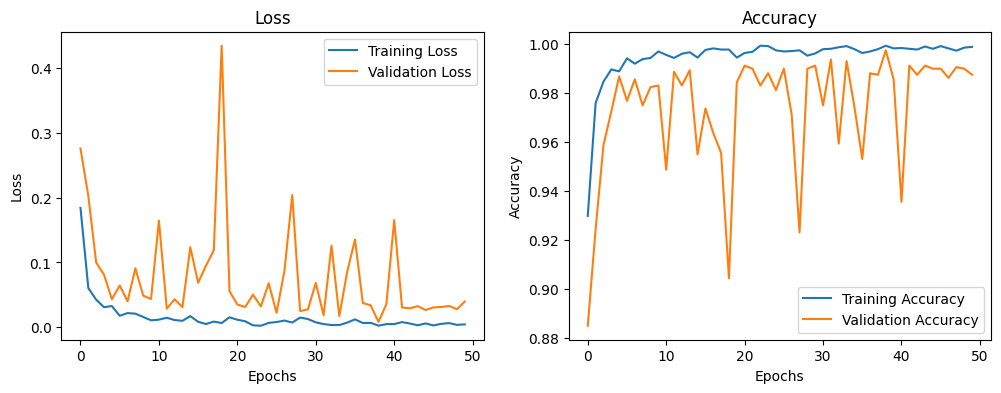

In [26]:
plot_learning_curve(history)

In [21]:
result = loaded_model.predict(X_test)
# 결과를 저장할 텍스트 파일 경로
output_file = 'small_final50_results_정상팀.txt'

# 반올림 및 변환 후 저장
with open(output_file, 'w') as file:
    for value in zip(result, files_test):
        rounded_value = np.round(value[0])  # 반올림
        gender = 'feml' if rounded_value == 0 else 'male'  # 0이면 'female', 1이면 'male'
        file.write(f"{value[1]}: {gender}\n")

32/32 [==============================] - 1s 36ms/step
